<a href="https://colab.research.google.com/github/MarkStephens060482/WildFires/blob/master/Wildfire_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Predictive modelling of Wildfires

A dataset based on Remote Sensing data related to the state of the crops (NDVI), meteorological conditions (LST), as well as the fire indicator “Thermal Anomalies”, these data, were acquired from “MODIS” (Moderate Resolution Imaging Spectroradiometer), a key instrument aboard the Terra and Aqua satellites. This dataset is available on GitHub via this link (https://github.com/ouladsayadyounes/Wildfires). The study area is composed of multiple zones located in the center of Canada.

The Dataset:

|Variables| Description|Type|
|:-------:|:----------:|:--:|
|NDVI| Normalised Difference Vegetation Index: indicates the state of crop health, it can be used to assess spatiotemporal changes in green vegetation.| *Float*|
|LST| Land Surface Temperature: represents the radiative skin temperature of land surface derived from solar radiation, depends on vegetation cover and th soi moisture.| Float|
|Burned_Area|


In [10]:
# importing libraries
import pandas as pd, numpy as np, seaborn as sns, matplotlib.pyplot as plt

In [11]:
#loadiong the dataset from GitHub
url = "https://raw.githubusercontent.com/MarkStephens060482/WildFires/master/WildFires_DataSet.csv"
data = pd.read_csv(url)

In [12]:
data.head()

,NDVI,LST,BURNED_AREA,CLASS
0,0.506782,14584.272727,4.692308,no_fire
1,0.522150,14655.833333,5.000000,no_fire
2,0.682284,14780.000000,5.000000,fire
3,0.120046,13298.500000,3.500000,no_fire
4,0.568734,14743.000000,5.000000,no_fire


### Pairplot
The numerical variables considered as possible predictors are examined, excluding *NDVI*, *LST* and *BURNED_AREA*. 

Text(0.5, 1.03, 'Pair plot of numerical predictors')

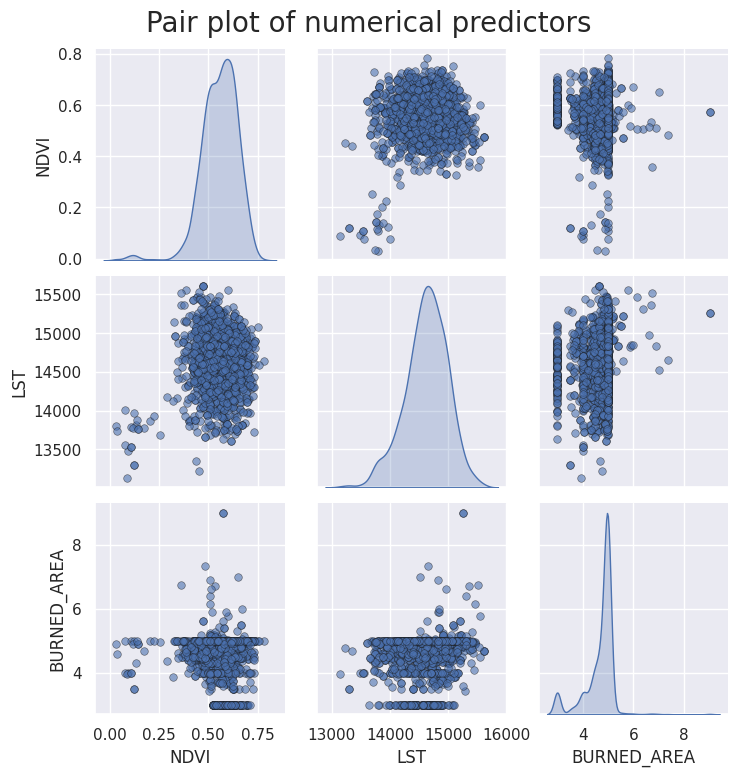

In [13]:
sns.pairplot(data,
             diag_kind = 'kde',
             plot_kws = {'alpha': 0.6, 's': 30, 'edgecolor': 'k'}
             )         
  # Title 
plt.suptitle(f'Pair plot of numerical predictors',
             size = 20,
             y=1.03)         

<Figure size 1400x1400 with 0 Axes>

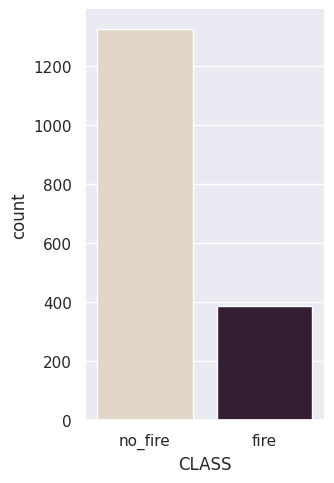

In [14]:
# set plot style: grey grid in the background:
sns.set(style="darkgrid")

# set the figure size
plt.figure(figsize=(14, 14))
sns.catplot(data=data, x="CLASS", kind="count", palette="ch:.25",aspect=.7)

### Preprocessing 
The data is normalised and a preprocessing step is defined in a pipeline. The categorical target variable is encoded. 

In [15]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import LabelEncoder

# Target encoding
le = LabelEncoder()

# Transform Target variable by encoding
le.fit_transform(data['CLASS'])

# define a minmax scaler to normalise minmax
minmax = MinMaxScaler()

# Create a pipeline for data preprocessing
preprocessor = make_pipeline(minmax)

Classification models used in ensemble model for wildfire classification using scikit-learn library.
- Random Forest Classifier
- Naive Bayes Classifier
- Support Vector Machine Classifier
- Multilayer Perceptron  Classifier
- Gradient Boosting Classifier

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import GradientBoostingClassifier

#create individual models
rf = RandomForestClassifier(n_estimators=100, random_state=42,class_weight = 'balanced')
nb = GaussianNB()
rbfsvc = SVC(kernel = "rbf",random_state=42,class_weight = 'balanced',probability =  True)
mlp = MLPClassifier(random_state=42)
gbc = GradientBoostingClassifier(random_state=42)

learner_weights = []
# Ensemble classifier 
ensemble_model = VotingClassifier([('SVC', rbfsvc), 
                       ('NBC', nb), 
                       ('MLPC', mlp), 
                       ('RFC', rf), 
                       ('GBC', gbc)],
                      voting = 'soft',
                      n_jobs = -1,
                      weights=learner_weights)


#### Dummy Regressor
Use a 'mean' strategy to establish a baseline for model performance.

In [17]:
from sklearn.dummy import DummyClassifier
# initiialise the dummy regressor
dummy = DummyClassifier(strategy='prior')

# list of base learners
models = [dummy,rf,nb,rbfsvc,mlp,gbc]

### Data Segregation
The data is split into 80%/20% train and test sets, stratified by the proportion of classes.  

In [22]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import RepeatedStratifiedKFold

#model predictors
X = data.drop('CLASS', axis=1) 

#target variable
y = data['CLASS']

# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify = y)

new_line = '\n'
print(f'Training dataset:{new_line}\
X_train = { X_train.shape} {new_line}\
y_train = { y_train.shape}{new_line}')

print(f'Testing dataset:{new_line}\
X_test = {X_test.shape}{new_line}\
y_test = {y_test.shape}')

n_splits = 5
n_repeats = 5

# Cross - validation strategy
CVsplitter = RepeatedStratifiedKFold(n_splits = n_splits, n_repeats = n_repeats,random_state = 42)

Training dataset:
X_train = (1370, 3) 
y_train = (1370,)

Testing dataset:
X_test = (343, 3)
y_test = (343,)


***
### Model fitting and Hyper parameter tuning
Both the untuned and tuned models are to be evaluated using cross validation. The models are looped through and the mean value and standard error of the scoring metrics of accuracy are determined under cross-validation.

In [19]:
from sklearn.model_selection import cross_validate

# define of estimators including the dummy regressor

metrics = ['accuracy', 'roc_auc']

model_scores = {}
# loop over the model pipelines
for model in models:
  pipeline = make_pipeline(preprocessor,model)

  # perform cross validation to get cv performance scores
  cv_results = cross_validate(pipeline,X_train,
                              y_train,
                              scoring =metrics,
                              cv = CVsplitter,
                              n_jobs=-1,                                   
                              verbose = 3)
  
  scores = []
  for metric in metrics:

    # determine mean, standard deviation and standard error of cv performance metric
    metric_mean = cv_results['test_' + metric].mean() 
    metric_stdev = cv_results['test_'+ metric].std() 
    metric_sterr = metric_stdev/np.sqrt(n_splits*n_repeats)

    # mean cross validationm scores with error
    metric_result = f'{metric_mean: .3f} \u00B1 {2*metric_sterr: .3f}'

    scores.append(metric_result)

  # append model name and cv score to list
  model_scores[pipeline.steps[1][0]] = scores
  
# express as a Data Frame
results_df = pd.DataFrame(model_scores,
                          index = ['accuracy','ROC_AUC'])
results_df

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  22 out of  25 | elapsed:    3.0s remaining:    0.4s
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    3.0s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    6.1s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    0.2s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    5.6s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:   11.9s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    4.3s finished


,dummyclassifier,randomforestclassifier,gaussiannb,svc,mlpclassifier,gradientboostingclassifier
accuracy,0.774 ± 0.001,0.819 ± 0.007,0.775 ± 0.004,0.621 ± 0.009,0.781 ± 0.004,0.793 ± 0.006
ROC_AUC,0.500 ± 0.000,0.801 ± 0.013,0.716 ± 0.012,0.726 ± 0.013,0.722 ± 0.012,0.772 ± 0.011


#### Hyper parameter tuning
The hyper parameters of each model are tuned using a hybrid approach of Randomised Search and Grid Search cross validation. The Randomised search identifies a ball park value for the optimum hyper parameter, while the grid seach will conduct a finer search within a range of some percentage either side of the value. 

#### Randomised Search

In [51]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from scipy.stats import uniform
from random import sample
import numpy as np

#defining the hyperparameter space ranges

# Support Vector Machine Classifier
# Examining verbose suggests that C >20 fails to converge.
C_range = np.logspace(-2,1.25,1000)
gamma_range = np.logspace(-2, 0.25, 1000)
epsilon_range = np.logspace(-1, 1.25, 1000)

# Random Forest Classifier parameters
n_estimators_range = sample(range(10, 1000), 100)
max_depth_range = sample(range(2, 10), 8)
min_samples_split_range =  sample(range(2, 10), 8)
min_samples_leaf_range = sample(range(1, 20), 19)
max_features_range = [1,2,3]

#GaussianNB parameter ranges
var_smoothing_range = np.logspace(-11, -7, 1000)

#MLPClassifier parameter ranges
alpha_range = np.logspace(-6, -1, 1000)

#Gradient Boosting parameter ranges
learning_rate_range = np.logspace(-3,1,1000)

#SVC parameters
random_param_svc = {'svc__C' : C_range,
                    'svc__epsilon': epsilon_range,
                    'svc__gamma' : gamma_range}

#RF parameters
random_param_rf = {'randomforestclassifier__n_estimators' : n_estimators_range,
                   'randomforestclassifier__max_depth': max_depth_range,
                   'randomforestclassifier__min_samples_split' : min_samples_split_range,
                   'randomforestclassifier__min_samples_leaf' : min_samples_leaf_range,
                   'randomforestclassifier__max_features' : max_features_range}

#GaussianNB parameters
random_param_nb = {'gaussiannb__var_smoothing' : var_smoothing_range}

#MLPClassifier parameters
random_param_mlpc = {'mlpclassifier__hidden_layer_sizes' : [(100,),(100,100),(100,100,100)],
                     'mlpclassifier__activation' : ['identity', 'logistic', 'tanh', 'relu'],
                     'mlpclassifier__alpha' : alpha_range}

#GradientBoosting
random_param_gbc = {'gradientboostingclassifier__learning_rate': learning_rate_range,
                    'gradientboostingclassifier__n_estimators': n_estimators_range,
                    'gradientboostingclassifier__min_samples_split':min_samples_split_range,
                    'gradientboostingclassifier__min_samples_leaf':min_samples_leaf_range,
                    'gradientboostingclassifier__max_depth':max_depth_range}

# [dummy,rf,nb,rbfsvc,mlp,gbc]
random_param_dummy = {'dummyclassifier__strategy' : ['prior']}

# parameters
parameters = [random_param_dummy,random_param_rf,random_param_nb,random_param_svc,random_param_mlpc,random_param_gbc]


# Conduct random search within the region of the optimal hyperparameters
tuned_models = []
for i,model in enumerate(models):
  pipeline = make_pipeline(preprocessor,model)
  random_grid = RandomizedSearchCV(pipeline,
                                   parameters[i],
                                   n_iter = 100,
                                   cv = CVsplitter,
                                   scoring = metrics,
                                   refit='accuracy',
                                   n_jobs = -1,
                                   verbose=3)
  # fit the model
  random_grid.fit(X_train, y_train)

  # get list of tuned models
  tuned_models.append(random_grid)

  # Get the best hyperparameters from the random search
  best_random = random_grid.best_params_

  new_line = '\n'
  print(f'{random_grid.estimator} has best hyper parameters for Randomised search are: {new_line}\
  {best_random}')

/usr/local/lib/python3.9/dist-packages/sklearn/model_selection/_search.py:305: UserWarning: The total space of parameters 1 is smaller than n_iter=100. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 25 folds for each of 1 candidates, totalling 25 fits
Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('minmaxscaler', MinMaxScaler())])),
                ('dummyclassifier', DummyClassifier())]) has best hyper parameters for Randomised search are: 
  {'dummyclassifier__strategy': 'prior'}
Fitting 25 folds for each of 100 candidates, totalling 2500 fits


KeyboardInterrupt: ignored

### Estimates of distribution of ratio of random variables as ensemble learner weights
The weights of the 'soft' voting ensemble Classifier are determined by the ratio of cross validation accuracy scores of individual learners. The weights for each base learner model $m_{i}$ is given by $w_{i} = {A_{i}\over ΣA_{i}}$, where $A_{i}$ is the cross-validation accuracy score for base learner $m_{i}$. The ratio of weights $R_{W}$ is given by ${A_{1}\over min(A_{i})}:{A_{2}\over min(A_{i})}:...:{A_{n}\over min(A_{i})}$ $∀  m_{i} ϵ M$ learners. The expected value of ${A_{i}\over min(A_{i})}$, which is of the form ${X\over Y}$, for dependent random variables is estimated to be $E({X\over Y}) ≈ {μ_{X}\over μ_{Y}} - {Cov(X,Y)\over (μ_{Y})^2}+{VAR(Y)μ_{X}\over \ (μ_{Y})^3}$. The variance of ${A_{i}\over min(A_{i})}$ is of the estimate $VAR({X\over Y}) ≈ {(μ_{X})^2\over (μ_{Y})^2}[{σ_{X}^2 \over (μ_{X})^2} - 2{COV(X,Y)\over μ_{X}μ_{Y}} +{σ_{Y}^2\over (μ_{Y})^2}]$  

